In [133]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [5]:
os.listdir('../data')

['dog',
 'cat',
 'wine_class.csv',
 'MSFT_AAPL.csv',
 'MSFT.csv',
 '.ipynb_checkpoints',
 'MSFT_AAPL_GOOGL.csv',
 'text.zip',
 'housing.csv',
 'sample.png']

In [22]:
df = pd.read_csv('../data/MSFT.csv')

In [23]:
df.shape

(1065, 5)

In [24]:
df.head()

,Date,Open,High,Low,Close
0,2014-01-02,37.350,37.40,37.10,37.16
1,2014-01-03,37.200,37.22,36.60,36.91
2,2014-01-06,36.850,36.89,36.11,36.13
3,2014-01-07,36.325,36.49,36.21,36.41
4,2014-01-08,36.000,36.14,35.58,35.76


In [25]:
df.dtypes

Date      object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object

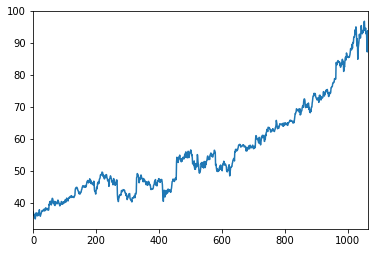

In [29]:
df['Close'].plot()

In [32]:
from fbprophet import Prophet

In [36]:
data = df.rename(columns={
    'Date': 'ds',
    'Close': 'y'
})
data.columns

Index(['ds', 'Open', 'High', 'Low', 'y'], dtype='object')

In [49]:
model = Prophet()
model.fit(data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [50]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [51]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-01-02,34.969007,34.969007,34.969007,34.133166,37.842304,0.993097,0.993097,0.993097,0.993097,0.993097,0.993097,-0.466271,-0.466271,-0.466271,1.459368,1.459368,1.459368,35.962104
1,2014-01-03,35.010176,35.010176,35.010176,34.194015,37.867421,1.085752,1.085752,1.085752,1.085752,1.085752,1.085752,-0.345158,-0.345158,-0.345158,1.430910,1.430910,1.430910,36.095927
2,2014-01-06,35.133681,35.133681,35.133681,34.426433,38.041591,1.029403,1.029403,1.029403,1.029403,1.029403,1.029403,-0.357374,-0.357374,-0.357374,1.386777,1.386777,1.386777,36.163084
3,2014-01-07,35.174849,35.174849,35.174849,34.308563,38.095610,0.942838,0.942838,0.942838,0.942838,0.942838,0.942838,-0.442137,-0.442137,-0.442137,1.384975,1.384975,1.384975,36.117687
4,2014-01-08,35.216017,35.216017,35.216017,34.237576,38.190188,0.963366,0.963366,0.963366,0.963366,0.963366,0.963366,-0.425248,-0.425248,-0.425248,1.388614,1.388614,1.388614,36.179383


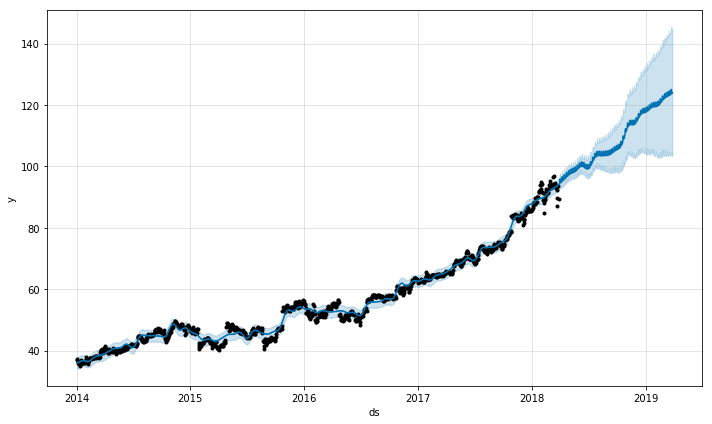

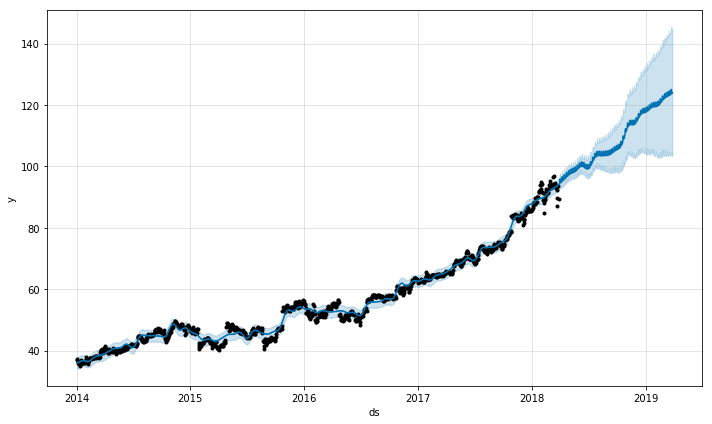

In [52]:
model.plot(forecast)

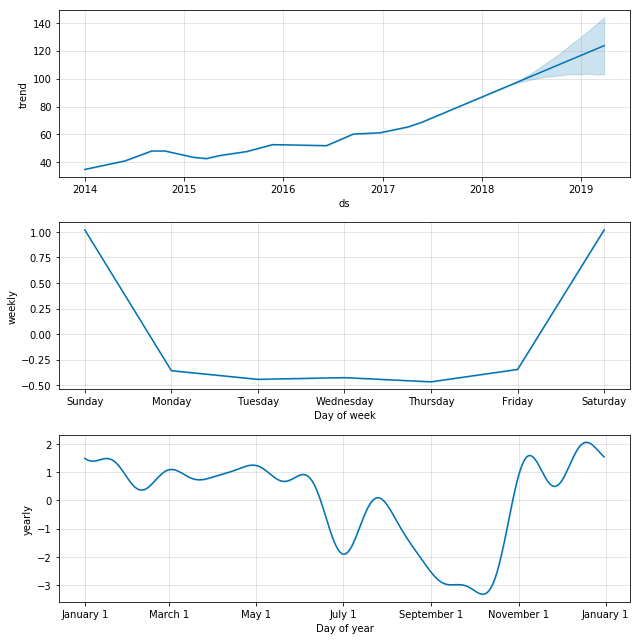

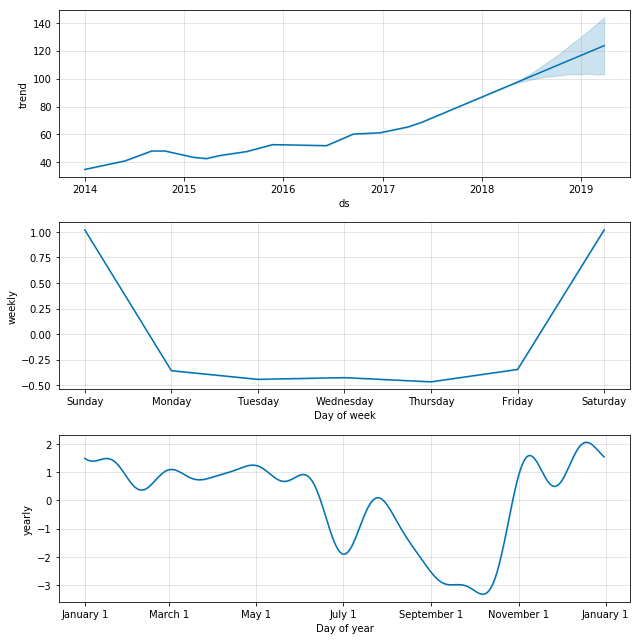

In [53]:
model.plot_components(forecast)

## 時系列モデルの実装

In [60]:
ts = df['Close'].values
ts.shape

(1065,)

In [75]:
np.diff([0, 1, 10])

array([1, 9])

In [63]:
ts[0], ts[1]

(37.16, 36.91)

* 今日より明日のほうが良ければ1 -> `ts[t+1] - ts[t] > 0`だったら１
* 最後のtsは、明日との差分が取れないのでサンプルから外す

In [100]:
x = ts[:-1]
t = (np.diff(ts) > 0).astype(int)
x.shape, t.shape

((1064,), (1064,))

In [101]:
x = x[:, np.newaxis].astype('float32')
t = t.astype('int32')
x.shape, t.shape

((1064, 1), (1064,))

データセットの作成

In [109]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer, extensions

from chainer.datasets import split_dataset

In [106]:
n_train = 1000

dataset = list(zip(x, t))
train, test = split_dataset(dataset, n_train)
len(train), len(test)

(1000, 64)

モデルの作成

In [146]:
class NN(chainer.Chain):
    def __init__(self, n_mid=10, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid)
            self.fc2 = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        return h

In [147]:
np.random.seed(0)

In [154]:
epoch = 10
gpu_id = -1
batchsize =100

# dataset iterator
train_iter = SerialIterator(train, batchsize)
test_iter = SerialIterator(test, batchsize, repeat=False)

# model
model = L.Classifier(NN())

optimizer = Adam().setup(model)
trainer = Trainer(StandardUpdater(train_iter, optimizer, device=gpu_id), 
                  (epoch, 'epoch'), out='result/rnn_1')

trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy',
                                       'validation/main/accuracy', 
                                       'main/loss', 'validation/main/loss', 
                                       'elapsed_time']), trigger=(1, 'epoch'))

In [155]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.517          0.5625                    0.768303    1.01908               0.0202107     
2           0.501          0.5625                    0.738329    0.690578              0.0535401     
3           0.521          0.4375                    0.720819    0.786615              0.0853236     
4           0.493          0.4375                    0.716047    0.800741              0.105594      
5           0.525          0.5625                    0.701603    0.688242              0.125876      
6           0.503          0.4375                    0.69261     0.70399               0.145819      
7           0.489          0.4375                    0.70089     0.733413              0.165846      
8           0.489          0.4375                    0.705173    0.717991              0.186432      
9           0.503          0.5625                    0.697057    0.689451           

In [168]:
def visualize_result():
    with open('result/rnn_1/log') as f:
        result = pd.DataFrame(json.load(f))

        
    print('Elapsed time: %d sec' % result.iloc[-1]['elapsed_time'])
    print('Validation accuracy:', result.iloc[-1]['validation/main/accuracy'])
    result[['main/accuracy', 'validation/main/accuracy']].plot()
    return result

Elapsed time: 0 sec
Validation accuracy: 0.4375


,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.060753,1,10,0.513,0.707741,0.562500,0.686387
1,0.105759,2,20,0.503,0.693537,0.437500,0.697139
2,0.150342,3,30,0.494,0.693726,0.437500,0.701262
3,0.197930,4,40,0.507,0.693834,0.437500,0.700440
4,0.242324,5,50,0.488,0.693472,0.437500,0.697717
5,0.287448,6,60,0.497,0.693251,0.437500,0.696228
6,0.332292,7,70,0.498,0.694013,0.453125,0.693026
7,0.376779,8,80,0.515,0.693281,0.437500,0.694138
8,0.421556,9,90,0.509,0.693153,0.437500,0.695270
9,0.468752,10,100,0.497,0.693201,0.437500,0.695247


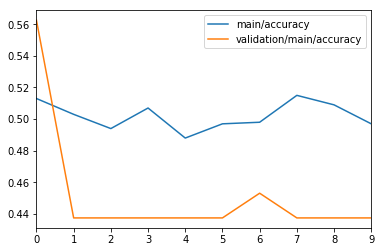

In [169]:
visualize_result()

RNNを試す

In [175]:
class RNN(chainer.Chain):

    def __init__(self, n_mid=10, n_out=2):
        super().__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None, n_mid)  # LSTMに変更
            self.fc = L.Linear(None, n_out)

    def __call__(self, x):
        self.reset_state()
        h = self.lstm(x)
        h = self.fc(h)
        return h

    # 状態をリセット
    def reset_state(self):
        self.lstm.reset_state()

In [176]:
import random

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

In [180]:
epoch = 100
gpu_id = 0
batchsize =100

# モデルの宣言
model = L.Classifier(RNN())
model.to_gpu(gpu_id)

# dataset iterator
train_iter = SerialIterator(train, batchsize)
test_iter = SerialIterator(test, batchsize, repeat=False)

# model
model = L.Classifier(RNN())

optimizer = Adam().setup(model)
trainer = Trainer(StandardUpdater(train_iter, optimizer, device=gpu_id), 
                  (epoch, 'epoch'), out='result/rnn_1')

# ここが一番違う
eval_model = model.copy()  # Model with shared params and distinct states
eval_rnn = eval_model.predictor
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id,
                                   eval_hook=lambda _: eval_rnn.reset_state()))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy',
                                       'validation/main/accuracy', 
                                       'main/loss', 'validation/main/loss', 
                                       'elapsed_time']), trigger=(1, 'epoch'))

In [181]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.513          0.5625                    0.700701    0.690285              0.0478268     
2           0.497          0.4375                    0.692713    0.69922               0.0932007     
3           0.504          0.4375                    0.693662    0.701115              0.137456      
4           0.492          0.4375                    0.693958    0.698495              0.182092      
5           0.494          0.4375                    0.693399    0.697115              0.226256      
6           0.501          0.4375                    0.693207    0.696198              0.271168      
7           0.489          0.4375                    0.693251    0.695795              0.316097      
8           0.495          0.4375                    0.693209    0.695131              0.365325      
9           0.504          0.4375                    0.693224    0.694924           

81          0.513          0.5625                    0.692928    0.691397              3.69949       
82          0.513          0.5625                    0.692844    0.691433              3.74573       
83          0.513          0.5625                    0.692926    0.691073              3.79471       
84          0.513          0.5625                    0.692843    0.690957              3.84083       
85          0.513          0.5625                    0.693043    0.690519              3.88596       
86          0.513          0.5625                    0.692925    0.691655              3.93197       
87          0.513          0.5625                    0.692858    0.69147               3.97842       
88          0.513          0.5625                    0.693078    0.69218               4.02353       
89          0.513          0.5625                    0.692999    0.690873              4.06847       
90          0.513          0.5625                    0.692853    0.690681         

Elapsed time: 4 sec
Validation accuracy: 0.5625


,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.047827,1,10,0.513,0.700701,0.5625,0.690285
1,0.093201,2,20,0.497,0.692713,0.4375,0.699220
2,0.137456,3,30,0.504,0.693662,0.4375,0.701115
3,0.182092,4,40,0.492,0.693958,0.4375,0.698495
4,0.226256,5,50,0.494,0.693399,0.4375,0.697115
5,0.271168,6,60,0.501,0.693207,0.4375,0.696198
6,0.316097,7,70,0.489,0.693251,0.4375,0.695795
7,0.365325,8,80,0.495,0.693209,0.4375,0.695131
8,0.411353,9,90,0.504,0.693224,0.4375,0.694924
9,0.455559,10,100,0.500,0.693194,0.4375,0.694751


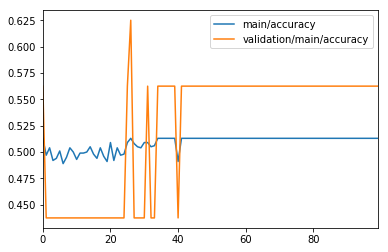

In [182]:
visualize_result()